In [25]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt

In [35]:
def otimizar_producao_com_graficos(dragons, habitats, tempo_coleta):
    model = cp_model.CpModel()
    D = range(len(dragons))
    H = range(len(habitats))

    # ----------------------------
    # Variáveis de alocação
    # ----------------------------
    x = {}
    for d in D:
        for h in H:
            x[d,h] = model.NewBoolVar(f"x_d{d}_h{h}")

    # Gold efetivo por habitat
    gold = {}
    for h in H:
        gold[h] = model.NewIntVar(0, habitats[h]["capacidade_gold"], f"gold_h{h}")

    # ----------------------------
    # Restrições
    # ----------------------------

    # 1. Cada dragão deve estar em exatamente um habitat
    for d in D:
        model.Add(sum(x[d,h] for h in H) == 1)

    # 2. Compatibilidade de tipos
    for d in D:
        for h in H:
            if dragons[d]["tipos"].isdisjoint(habitats[h]["tipos"]):
                model.Add(x[d,h] == 0)

    # 3. Limite de dragões por habitat
    for h in H:
        model.Add(sum(x[d,h] for d in D) <= habitats[h]["limite_dragoes"])

    # 4. Gold efetivo (até capacidade)
    for h in H:
        total_producao = sum(dragons[d]["producao"] * tempo_coleta * x[d,h] for d in D)
        model.Add(gold[h] <= total_producao)
        model.Add(gold[h] <= habitats[h]["capacidade_gold"])

    # ----------------------------
    # Objetivo: maximizar gold efetivo
    # ----------------------------
    model.Maximize(sum(gold[h] for h in H))

    # ----------------------------
    # Resolver
    # ----------------------------
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("Nenhuma solução encontrada.")
        return

    # ----------------------------
    # Resultado
    # ----------------------------
    print("\n=== Alocação otimizada ===")
    for d in D:
        for h in H:
            if solver.Value(x[d,h]) == 1:
                print(f"Dragão {dragons[d]['id']} -> Habitat {habitats[h]['id']} ({dragons[d]['producao']} gold/min)")

    print("\nGold efetivo e overflow por habitat:")
    gold_coletado = []
    overflow = []
    nomes_habitats = []
    for h in H:
        total_producao = sum(dragons[d]["producao"] * tempo_coleta * solver.Value(x[d,h]) for d in D)
        coletado = solver.Value(gold[h])
        gold_coletado.append(coletado)
        overflow.append(total_producao - coletado)
        nomes_habitats.append(habitats[h]["id"])
        print(f"Habitat {habitats[h]['id']}: coletado={coletado}, overflow={total_producao - coletado}")

    print(f"\nProdução total efetiva: {sum(solver.Value(gold[h]) for h in H)} gold")

    # ----------------------------
    # Gráfico de barras
    # ----------------------------
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(nomes_habitats, gold_coletado, label="Gold Coletado", color='gold')
    ax.bar(nomes_habitats, overflow, bottom=gold_coletado, label="Overflow", color='red', alpha=0.6)
    ax.set_ylabel("Gold")
    ax.set_title("Distribuição de Gold por Habitat")
    ax.legend()
    plt.show()


=== Alocação otimizada ===
Dragão D1 -> Habitat H2 (500 gold/min)
Dragão D2 -> Habitat H2 (100 gold/min)
Dragão D3 -> Habitat H3 (1500 gold/min)

Gold efetivo e overflow por habitat:
Habitat H1: coletado=0, overflow=0
Habitat H2: coletado=36000, overflow=0
Habitat H3: coletado=60000, overflow=30000

Produção total efetiva: 96000 gold


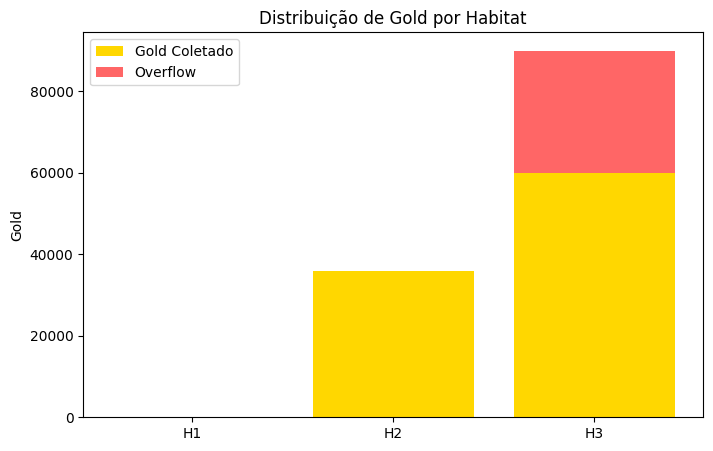

In [38]:
dragons = [
    {"id": "D1", "tipos": {"fogo", "terra"}, "producao": 500},
    {"id": "D2", "tipos": {"terra"}, "producao": 100},
    {"id": "D3", "tipos": {"agua", "fogo"}, "producao": 1500},
]

habitats = [
    {"id": "H1", "tipos": {"fogo"}, "capacidade_gold": 20000, "limite_dragoes": 2},
    {"id": "H2", "tipos": {"terra"}, "capacidade_gold": 40000, "limite_dragoes": 2},
    {"id": "H3", "tipos": {"agua"}, "capacidade_gold": 60000, "limite_dragoes": 1},
]

tempo_coleta = 60  # minutos

otimizar_producao_com_graficos(dragons, habitats, tempo_coleta)
